In [29]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
from sklearn.metrics import pairwise
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import resample

In [30]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [31]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1600])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1600])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# SVM-RFE

In [45]:
@time_func
def SVM_RFE_W_STEP(mode = 'const', step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=3):
    data.kernel = kernel
    #data.kernel_matrix = kernel
    data.C = C
    data.C2 = C
    data.gamma = gamma
    data.degree = degree
    kf = KFold(n_splits=7, shuffle=True)

    def Xresample(X0):
        return resample(X0, replace=False, n_samples = int(X0.shape[0]*percentage))

    if mode == 'outsample':
        index = [(Xresample(train_index), test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe, index)
    if mode == 'sample':
        index = [(train_index, test_index, step, percentage) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_sampling, index)

    #scores = list(map(data.svm_rfe_dynamic_step, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(mode, C, step)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

outsample 1e-05 500


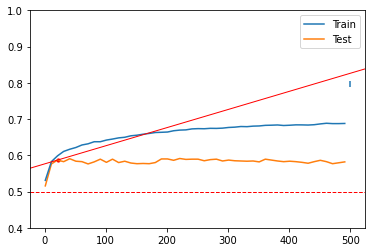

AT (21, 0.5868875244880761, 0.33888998040953916) WITH 1 ITERATIONS IN 0.4063143389565604 SECONDS : 0.0010442141029643052
__main__.SVM_RFE_W_STEP - 00:00:05.989851800


((21, 0.5868875244880761, 0.33888998040953916), 0.4063143389565604)

In [47]:
SVM_RFE_W_STEP('outsample', C=0.00001, percentage=1.0, step=500, kernel='liblinear')

outsample 1e-05 500


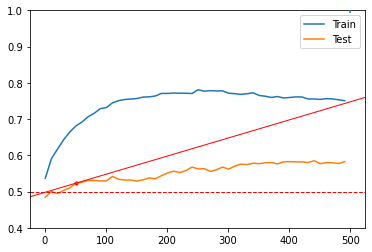

AT (51, 0.5231172910442045, 0.40190616716463645) WITH 1 ITERATIONS IN 1.3872754914419991 SECONDS : 0.06496125781856966
__main__.SVM_RFE_W_STEP - 00:00:05.206439900


((51, 0.5231172910442045, 0.40190616716463645), 1.3872754914419991)

In [48]:
SVM_RFE_W_STEP('outsample', C=0.00001, percentage=0.5, step=100, kernel='liblinear')

In [ ]:
SVM_RFE_W_STEP('sample', C=0.00001, percentage=0.5, step=100, kernel='liblinear')

outsample 1e-05 10


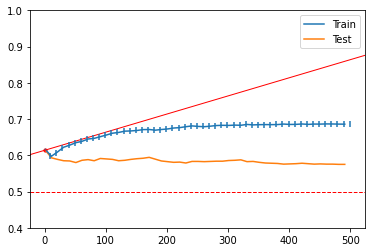

AT (1, 0.6144044609339944, 0.30887643125280456) WITH 50 ITERATIONS IN 2.1013900552477156 SECONDS : 0.008149542517713245
__main__.SVM_RFE_W_STEP - 00:00:07.262629000


((1, 0.6144044609339944, 0.30887643125280456), 2.1013900552477156)

In [33]:
SVM_RFE_W_STEP('outsample', C=0.00001, percentage=1.0, kernel='liblinear')

outsample 1e-05 10


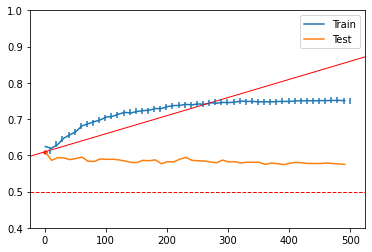

AT (1, 0.6099801906513008, 0.3124158474789594) WITH 50 ITERATIONS IN 0.9068797997065953 SECONDS : 0.001949254129870645
__main__.SVM_RFE_W_STEP - 00:00:04.734202000


((1, 0.6099801906513008, 0.3124158474789594), 0.9068797997065953)

In [34]:
SVM_RFE_W_STEP('outsample', C=0.00001, percentage=0.5, kernel='liblinear')

sample 1e-05 10


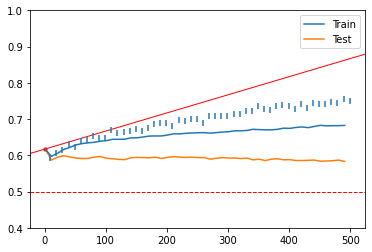

AT (1, 0.6174962515458953, 0.3064029987632838) WITH 50 ITERATIONS IN 1.722921507699149 SECONDS : 0.0001534305558973812
__main__.SVM_RFE_W_STEP - 00:00:07.090676500


((1, 0.6174962515458953, 0.3064029987632838), 1.722921507699149)

In [35]:
SVM_RFE_W_STEP('sample', C=0.00001, percentage=0.5, kernel='liblinear')

outsample 1e-05 10


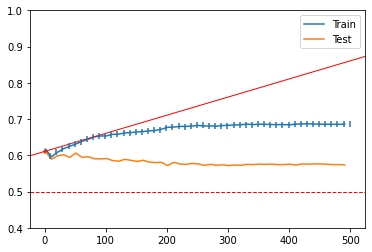

AT (1, 0.6112579483643606, 0.3113936413085115) WITH 50 ITERATIONS IN 2.0321666172572543 SECONDS : 0.001120045751623384
__main__.SVM_RFE_W_STEP - 00:00:07.317585100
outsample 0.0001 10


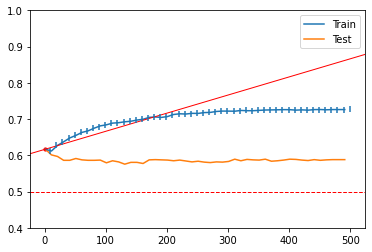

AT (1, 0.6168368519552155, 0.3069305184358276) WITH 50 ITERATIONS IN 2.6324403967176164 SECONDS : 0.0016920458036097166
__main__.SVM_RFE_W_STEP - 00:00:08.309606600
outsample 0.001 10


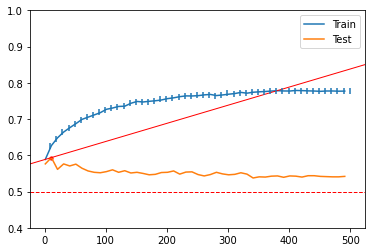

AT (11, 0.5937496579877642, 0.32940027360978863) WITH 50 ITERATIONS IN 3.954874345234462 SECONDS : 0.00486724421160739
__main__.SVM_RFE_W_STEP - 00:00:11.382492500
outsample 0.01 10


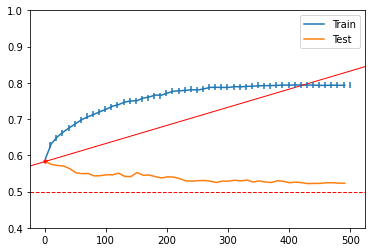

AT (1, 0.5830734040341028, 0.3339412767727178) WITH 50 ITERATIONS IN 6.509801694325039 SECONDS : 0.007879735121178429
__main__.SVM_RFE_W_STEP - 00:00:15.745341700
outsample 0.1 10


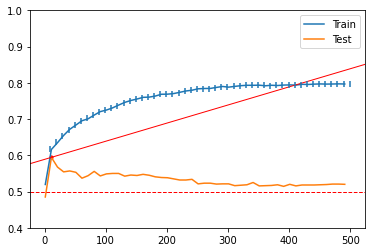

AT (11, 0.5944063214805573, 0.32887494281555424) WITH 50 ITERATIONS IN 8.899606398173741 SECONDS : 0.029806246545599515
__main__.SVM_RFE_W_STEP - 00:00:21.361239500
outsample 1e-05 10


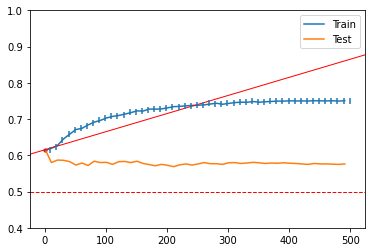

AT (1, 0.6156357049829815, 0.30789143601361485) WITH 50 ITERATIONS IN 0.9124094758714948 SECONDS : 0.0011196879421945319
__main__.SVM_RFE_W_STEP - 00:00:04.785606800
outsample 0.0001 10


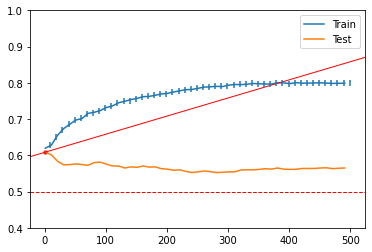

AT (1, 0.6087407383086537, 0.31340740935307704) WITH 50 ITERATIONS IN 1.046022619519915 SECONDS : 0.0014286788687453442
__main__.SVM_RFE_W_STEP - 00:00:05.104295900
outsample 0.001 10


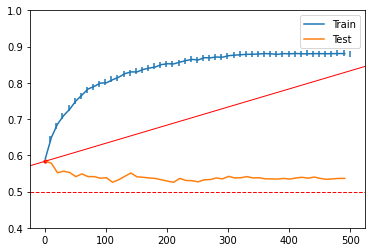

AT (1, 0.5837546924078756, 0.33339624607369955) WITH 50 ITERATIONS IN 1.580172368458339 SECONDS : 0.0007547095209265907
__main__.SVM_RFE_W_STEP - 00:00:06.234267800
outsample 0.01 10


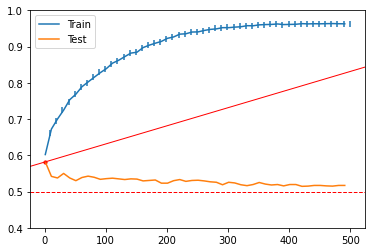

AT (1, 0.5819187707259416, 0.3348649834192468) WITH 50 ITERATIONS IN 2.7568473475319997 SECONDS : 0.005935574609329521
__main__.SVM_RFE_W_STEP - 00:00:08.421295100
outsample 0.1 10


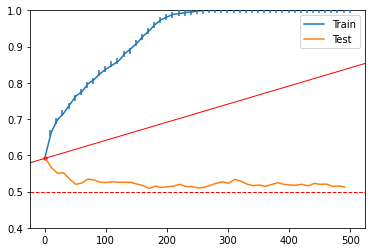

AT (1, 0.5919027919142835, 0.3268777664685732) WITH 50 ITERATIONS IN 5.184297255107334 SECONDS : 0.05819520391608478
__main__.SVM_RFE_W_STEP - 00:00:13.180380700
outsample 1e-05 10


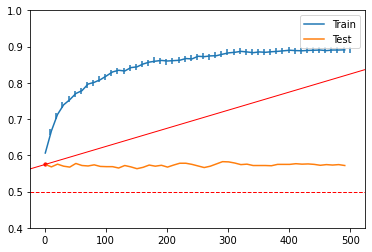

AT (1, 0.5749280406255816, 0.34045756749953476) WITH 50 ITERATIONS IN 0.27182960510253906 SECONDS : 0.0003218634471977566
__main__.SVM_RFE_W_STEP - 00:00:03.401040600
outsample 0.0001 10


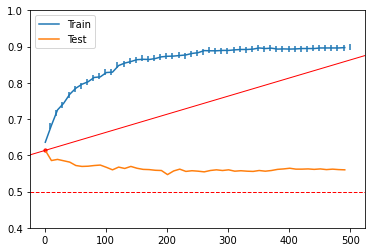

AT (1, 0.6137286447559948, 0.30941708419520425) WITH 50 ITERATIONS IN 0.30117665018354145 SECONDS : 0.00011604334557265545
__main__.SVM_RFE_W_STEP - 00:00:03.455277200
outsample 0.001 10


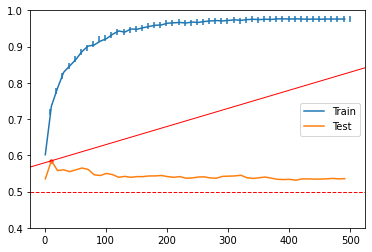

AT (11, 0.5849695198695428, 0.33642438410436576) WITH 50 ITERATIONS IN 0.38200654302324566 SECONDS : 0.00031235237715036975
__main__.SVM_RFE_W_STEP - 00:00:03.671946300
outsample 0.01 10


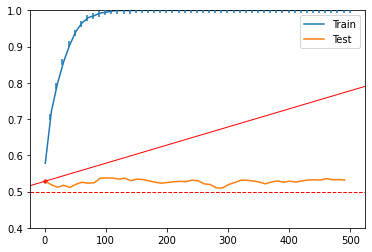

AT (1, 0.528729027809699, 0.37741677775224086) WITH 50 ITERATIONS IN 0.6163215637207031 SECONDS : 0.000606762719517714
__main__.SVM_RFE_W_STEP - 00:00:04.068310700
outsample 0.1 10


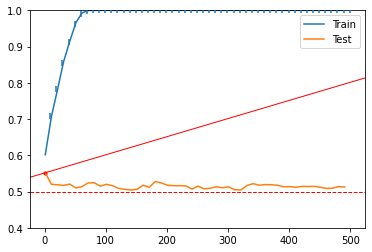

AT (1, 0.5519284017905024, 0.35885727856759814) WITH 50 ITERATIONS IN 1.8716939858027868 SECONDS : 0.01785990662376105
__main__.SVM_RFE_W_STEP - 00:00:06.529319300


In [36]:
model_selection = {}
for p in [1.0, 0.5, 0.2]:
    for C in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
        model_selection[C, p] = SVM_RFE_W_STEP('outsample', C=C, percentage=p)

In [37]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} &     1 & 61.13\% & 0.311 &     1 & 61.56\% & 0.308 &     1 & 57.49\% & 0.340\\
\textbf{0.000100} &     1 & 61.68\% & 0.307 &     1 & 60.87\% & 0.313 &     1 & 61.37\% & 0.309\\
\textbf{0.001000} &    11 & 59.37\% & 0.329 &     1 & 58.38\% & 0.333 &    11 & 58.50\% & 0.336\\
\textbf{0.010000} &     1 & 58.31\% & 0.334 &     1 & 58.19\% & 0.335 &     1 & 52.87\% & 0.377\\
\textbf{0.100000} &    11 & 59.44\% & 0.329 &     1 & 59.19\% & 0.327 &     1 & 55.19\% & 0.359\\


In [38]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:02.032 & 0:00.912 & 0:00.271\\
\textbf{0.000100} & 0:02.632 & 0:01.046 & 0:00.301\\
\textbf{0.001000} & 0:03.954 & 0:01.580 & 0:00.382\\
\textbf{0.010000} & 0:06.509 & 0:02.756 & 0:00.616\\
\textbf{0.100000} & 0:08.899 & 0:05.184 & 0:01.871\\


sample 1e-05 10


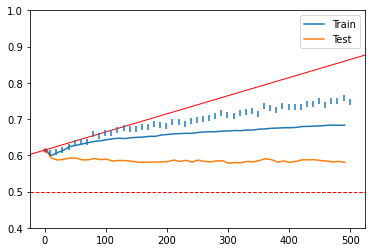

AT (1, 0.6150364995458079, 0.30837080036335374) WITH 50 ITERATIONS IN 1.6679694652557373 SECONDS : 0.0005649910911935356
__main__.SVM_RFE_W_STEP - 00:00:06.907892000
sample 0.0001 10


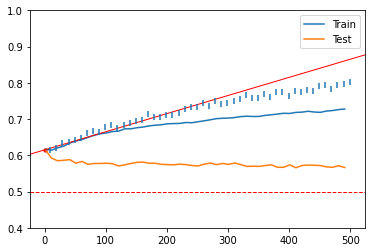

AT (1, 0.6156083440041151, 0.3079133247967079) WITH 50 ITERATIONS IN 1.851858275277274 SECONDS : 0.0010412256477148006
__main__.SVM_RFE_W_STEP - 00:00:07.589715700
sample 0.001 10


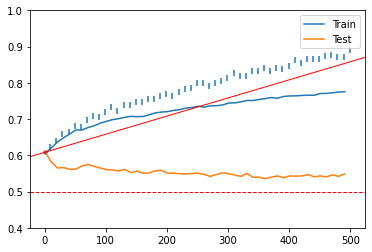

AT (1, 0.6087680992875201, 0.313385520569984) WITH 50 ITERATIONS IN 2.3599245888846263 SECONDS : 0.0014414616278962018
__main__.SVM_RFE_W_STEP - 00:00:09.280283500
sample 0.01 10


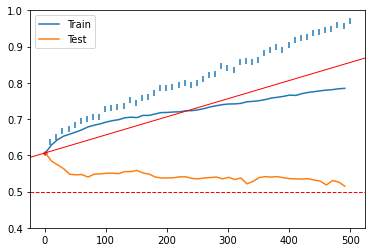

AT (1, 0.6068336780816671, 0.3149330575346663) WITH 50 ITERATIONS IN 3.591251475470407 SECONDS : 0.0011063960354226303
__main__.SVM_RFE_W_STEP - 00:00:12.269700000
sample 0.1 10


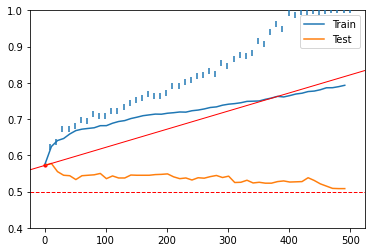

AT (1, 0.5725284827789999, 0.3423772137768001) WITH 50 ITERATIONS IN 5.995781081063407 SECONDS : 0.007407130005160478
__main__.SVM_RFE_W_STEP - 00:00:16.564925100
sample 1e-05 10


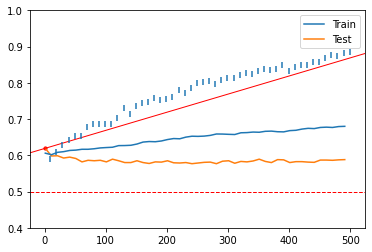

AT (1, 0.6194142561644286, 0.30486859506845715) WITH 50 ITERATIONS IN 0.6638335159846714 SECONDS : 0.0007229235909377093
__main__.SVM_RFE_W_STEP - 00:00:06.215030100
sample 0.0001 10


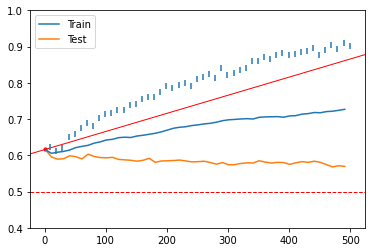

AT (1, 0.6163060489652078, 0.3073551608278338) WITH 50 ITERATIONS IN 0.6402038165501186 SECONDS : 0.0005264885378252
__main__.SVM_RFE_W_STEP - 00:00:06.584833200
sample 0.001 10


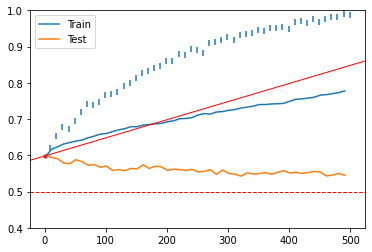

AT (1, 0.5987129395541254, 0.3214296483566997) WITH 50 ITERATIONS IN 0.6738792487553188 SECONDS : 0.00039266768039294904
__main__.SVM_RFE_W_STEP - 00:00:07.541168500
sample 0.01 10


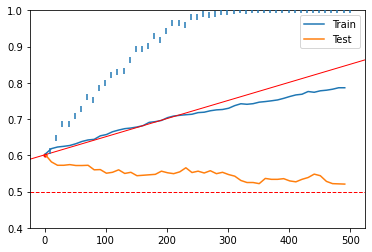

AT (1, 0.6018320911448928, 0.3189343270840858) WITH 50 ITERATIONS IN 0.9045060362134661 SECONDS : 0.0001073816746500189
__main__.SVM_RFE_W_STEP - 00:00:09.547932300
sample 0.1 10


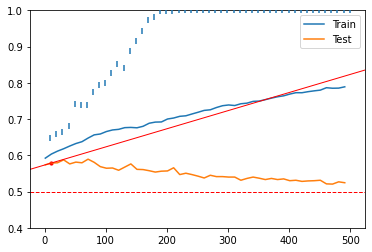

AT (11, 0.5787722581563077, 0.34138219347495385) WITH 50 ITERATIONS IN 2.2372303349631175 SECONDS : 0.0035666822742124
__main__.SVM_RFE_W_STEP - 00:00:12.362829900
sample 1e-05 10


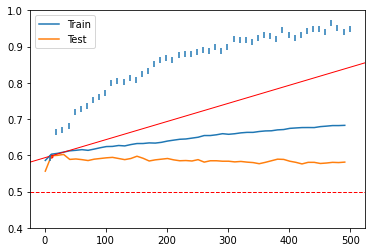

AT (11, 0.5986992590646922, 0.32544059274824627) WITH 50 ITERATIONS IN 0.2804010936192104 SECONDS : 0.00013468553021891923
__main__.SVM_RFE_W_STEP - 00:00:05.448240700
sample 0.0001 10


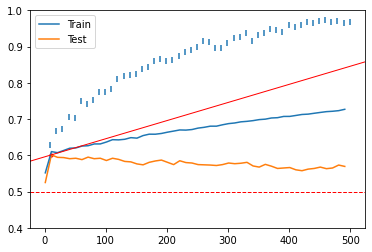

AT (11, 0.6012985520569983, 0.3233611583544014) WITH 50 ITERATIONS IN 0.2805714266640799 SECONDS : 0.00014375728030746374
__main__.SVM_RFE_W_STEP - 00:00:05.930563300
sample 0.001 10


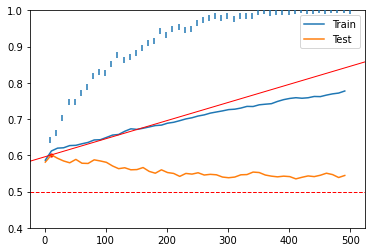

AT (11, 0.6012684549802454, 0.3233852360158037) WITH 50 ITERATIONS IN 0.2965278284890311 SECONDS : 0.00018022739403263864
__main__.SVM_RFE_W_STEP - 00:00:07.162653800
sample 0.01 10


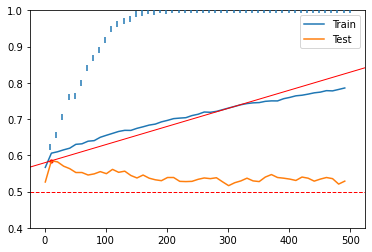

AT (11, 0.585021505729389, 0.3363827954164888) WITH 50 ITERATIONS IN 0.37483504840305876 SECONDS : 0.0001302403373403872
__main__.SVM_RFE_W_STEP - 00:00:09.129320300
sample 0.1 10


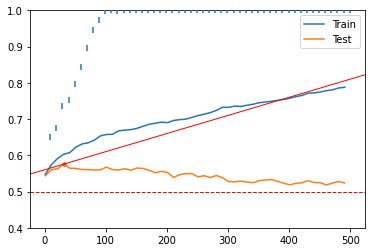

AT (31, 0.5756448982718806, 0.35188408138249555) WITH 50 ITERATIONS IN 0.6988621779850551 SECONDS : 0.00031732405149369344
__main__.SVM_RFE_W_STEP - 00:00:10.817602500


In [39]:
model_selection = {}
for step in [0.5, 0.2, 0.1]:
    for C in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
        model_selection[C, step] = SVM_RFE_W_STEP('sample', C=C, percentage=step)

In [42]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    {0.5: 1, 0.2: 2, 0.1: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} &     1 & 61.50\% & 0.308 &     1 & 61.94\% & 0.305 &    11 & 59.87\% & 0.325\\
\textbf{0.000100} &     1 & 61.56\% & 0.308 &     1 & 61.63\% & 0.307 &    11 & 60.13\% & 0.323\\
\textbf{0.001000} &     1 & 60.88\% & 0.313 &     1 & 59.87\% & 0.321 &    11 & 60.13\% & 0.323\\
\textbf{0.010000} &     1 & 60.68\% & 0.315 &     1 & 60.18\% & 0.319 &    11 & 58.50\% & 0.336\\
\textbf{0.100000} &     1 & 57.25\% & 0.342 &    11 & 57.88\% & 0.341 &    31 & 57.56\% & 0.352\\


In [43]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.5: 1, 0.2: 2, 0.1: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:01.667 & 0:00.663 & 0:00.280\\
\textbf{0.000100} & 0:01.851 & 0:00.640 & 0:00.280\\
\textbf{0.001000} & 0:02.359 & 0:00.673 & 0:00.296\\
\textbf{0.010000} & 0:03.591 & 0:00.904 & 0:00.374\\
\textbf{0.100000} & 0:05.995 & 0:02.237 & 0:00.698\\
